<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe67701-uncertainty-quantification](https://ndcbe.github.io/cbe67701-uncertainty-quantification);
content is available [on Github](git@github.com:ndcbe/cbe67701-uncertainty-quantification.git).*

<!--NAVIGATION-->
< [7.0 Sampling-Based Uncertainty Quantification: Monte Carlo and Beyond](https://ndcbe.github.io/cbe67701-uncertainty-quantification/07.00-Sampling-Based-Uncertainty-Quantification.html) | [Contents](toc.html) | [7.2 Meaningful Title Goes Here](https://ndcbe.github.io/cbe67701-uncertainty-quantification/07.02-Contributed-Example.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/07.01-Sampling-Based-Uncertainty-Quantification.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/07.01-Sampling-Based-Uncertainty-Quantification.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 7.1 Latin Hypercube and Quasi-Monte Carlo Sampling

Created by Dezhao Huang (dhuang2@nd.edu)

These examples and codes were adapted from:
* https://risk-engineering.org/notebook/monte-carlo-LHS.html
* McClarren, Ryan G (2018). *Uncertainty Quantification and Predictive Computational Science: A Foundation for Physical Scientists and Engineers*, *Chapter 7 : Sampling-Based Uncertainty Quantification Monte Carlo and Beyond*, Springer, https://link.springer.com/chapter/10.1007%2F978-3-319-99525-0_7

## Chapter 7 Overview

1. Basic Monte Carlo methods: maximum likelihood estimation and methods of moments
2. Design based sampling: Latin Hypercube Sampling
3. Quasi-Monte Carlo: Halton sequences and Sobol sequence

In [1]:
# Load libraries
import math
import numpy
import scipy.stats
import matplotlib.pyplot as plt
plt.style.use("bmh")
import sympy
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
## Install missing packages
!pip install sobol_seq

import sobol_seq

!pip install pyDOE
from pyDOE import lhs

In [3]:
# Download figures (if needed)
import os, requests, urllib

# GitHub pages url
url = "https://ndcbe.github.io/cbe67701-uncertainty-quantification/"

# relative file paths to download
# this is the only line of code you need to change
file_paths = ['figures/LHS.png']

# loop over all files to download
for file_path in file_paths:
    print("Checking for",file_path)
    # split each file_path into a folder and filename
    stem, filename = os.path.split(file_path)
    
    # check if the folder name is not empty
    if stem:
        # check if the folder exists
        if not os.path.exists(stem):
            print("\tCreating folder",stem)
            # if the folder does not exist, create it
            os.mkdir(stem)
    # if the file does not exist, create it by downloading from GitHub pages
    if not os.path.isfile(file_path):
        file_url = urllib.parse.urljoin(url,
                urllib.request.pathname2url(file_path))
        print("\tDownloading",file_url)
        with open(file_path, 'wb') as f:
            f.write(requests.get(file_url).content)
    else:
        print("\tFile found!")

Checking for figures/LHS.png
	File found!


The simplest 1D integration problem, 

$\int_1^5 x^2$

We can estimate this integral using a standard Monte Carlo method, where we use the fact that the expectation of a random variable is related to its integral

$\mathbb{E}(f(x)) = \int_I f(x) dx$

We will sample a large number $N$ of points in $I$ and calculate their average, and multiply by the range over which we are integrating.


In [4]:
# First, let's take a look at the analytical result:
result = {}  
x = sympy.Symbol("x")
i = sympy.integrate(x**2)
result["analytical"] = float(i.subs(x, 5) - i.subs(x, 1))
print("Analytical result: {}".format(result["analytical"]))

Analytical result: 41.333333333333336


Monte Carlo Simulator : $<F^N> = (b-a)\frac{1}{N}\sum_{i = 0}^{N-1} f(x_i)$

In [5]:
# Second, use the simple monte carlo method to calculate the integral
N = 1000
accum = 0
for i in range(N):
    x = numpy.random.uniform(1, 5)
    accum += x**2
interval_length = 5 - 1
result["MC"] = interval_length * accum / float(N)
print("Simple Monte Carlo result: {}".format(result["MC"]))


Simple Monte Carlo result: 40.6994232474979


## 7.1.1 Latin hypercube sampling

Try to pick a design that fills the design space given a fixed number of samples.

The LHS figure below is from McClarren (2018).

![](./figures/LHS.png)


In [6]:
N = 1000

seq = lhs(2, N)
accum = 0
for i in range(N):
    x = 1 + seq[i][0]*(5 - 1)
    y = 1 + seq[i][1]*(5**2 - 1**2)
    accum += x**2
volume = 5 - 1
result["LHS"] = volume * accum / float(N)
print("Latin hypercube result: {}".format(result["LHS"]))

Latin hypercube result: 41.33359084466315


## 7.1.2 Quasi MC: Halton’s low discrepency sequences

Quasi-Monte Carlo(QMC) simulation is the traditional MCS but using deterministic sequences.

A [low discrepancy (or quasi-random) sequence](https://en.wikipedia.org/wiki/Low-discrepancy_sequence) is a deterministic mathematical sequence of numbers that has the property of low discrepancy. This means that there are no clusters of points and that the sequence fills space roughly uniformly. The [Halton sequence](https://en.wikipedia.org/wiki/Halton_sequence) is a low discrepancy sequence that has useful properties for pseudo-stochastic sampling methods (also called “quasi-Monte Carlo” methods).

In [7]:
def halton(dim: int, nbpts: int):
    h = numpy.full(nbpts * dim, numpy.nan)
    p = numpy.full(nbpts, numpy.nan)
    P = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31]
    lognbpts = math.log(nbpts + 1)
    for i in range(dim):
        b = P[i]
        n = int(math.ceil(lognbpts / math.log(b)))
        for t in range(n):
            p[t] = pow(b, -(t + 1))
        for j in range(nbpts):
            d = j + 1
            sum_ = math.fmod(d, b) * p[0]
            for t in range(1, n):
                d = math.floor(d / b)
                sum_ += math.fmod(d, b) * p[t]

            h[j*dim + i] = sum_
    return h.reshape(nbpts, dim)

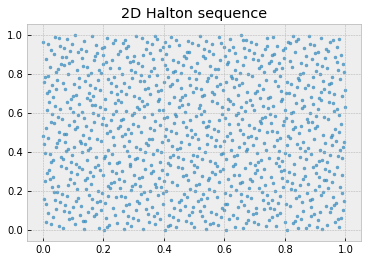

In [8]:
N = 1000
seq = halton(2, N)
plt.title("2D Halton sequence")
plt.scatter(seq[:,0], seq[:,1], marker=".", alpha=0.7);

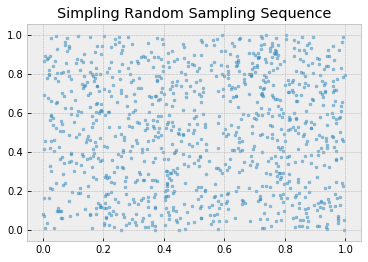

In [9]:
N = 1000
plt.title("Simpling Random Sampling Sequence")
plt.scatter(numpy.random.uniform(size=N), numpy.random.uniform(size=N), marker=".", alpha=0.5);

In [10]:
seq = halton(2, N)
accum = 0
for i in range(N):
    x = 1 + seq[i][0]*(5 - 1)
    y = 1 + seq[i][1]*(5**2 - 1**2)
    accum += x**2
volume = 5 - 1
result["QMCH"] = volume * accum / float(N)
print("Quasi-Monte Carlo result (Halton): {}".format(result["QMCH"]))

Quasi-Monte Carlo result (Halton): 41.21870562744141


Another quasi-random sequence commonly used for this purpose is the **Sobol’ sequence**. This equence was designed to make integral estiamtes on the p-dimensional hypercube converge as quickly as possible.

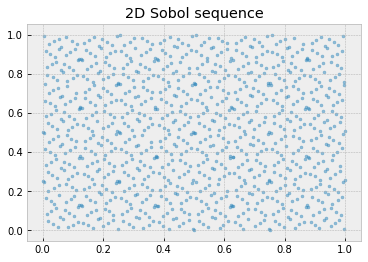

In [11]:
seq = sobol_seq.i4_sobol_generate(2, N)
plt.title("2D Sobol sequence")
plt.scatter(seq[:,0], seq[:,1], marker=".", alpha=0.5);

In [12]:
seq = sobol_seq.i4_sobol_generate(2, N)

accum = 0
for i in range(N):
    x = 1 + seq[i][0]*(5 - 1)
    y = 1 + seq[i][1]*(5**2 - 1**2)
    accum += x**2
volume = 5 - 1
result["QMCS"] = volume * accum / float(N)
print("Quasi-Monte Carlo result (Sobol): {}".format(result["QMCS"]))

Quasi-Monte Carlo result (Sobol): 41.31674468994141


## 7.1.3 Comparison (1 dimensional)

We can compare the error of our different estimates (each used the same number of runs):

In [13]:
for m in ["MC", "LHS", "QMCH", "QMCS"]:
    print("{:4} result: {:.8}  Error: {:E}".format(m, result[m], abs(result[m]-result["analytical"])))

MC   result: 40.699423  Error: 6.339101E-01
LHS  result: 41.333591  Error: 2.575113E-04
QMCH result: 41.218706  Error: 1.146277E-01
QMCS result: 41.316745  Error: 1.658864E-02


<!--NAVIGATION-->
< [7.0 Sampling-Based Uncertainty Quantification: Monte Carlo and Beyond](https://ndcbe.github.io/cbe67701-uncertainty-quantification/07.00-Sampling-Based-Uncertainty-Quantification.html) | [Contents](toc.html) | [7.2 Meaningful Title Goes Here](https://ndcbe.github.io/cbe67701-uncertainty-quantification/07.02-Contributed-Example.html)<p><a href="https://colab.research.google.com/github/ndcbe/cbe67701-uncertainty-quantification/blob/master/docs/07.01-Sampling-Based-Uncertainty-Quantification.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/cbe67701-uncertainty-quantification/07.01-Sampling-Based-Uncertainty-Quantification.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>